In [1]:
import tensorflow as tf
import keras
import numpy as np

In [ ]:
# Don't run the below codes(pseudo codes)

In [ ]:
# Pseudocode of RNN 

state_t = 0  # Intial current state of the RNN cell
for input_t in input_sequence: # input_t is the inputs present in the current sequence ( So RNN iterates over the input sequence considering each input present in the current sequence)
    output_t = function(input_t, state_t) # The output of the RNN in time 't' calculated as a function of input at time 't' and state at time 't'
    state_t = output_t  # Update the current state of the RNN cell ( This will then be the input state of the RNN cell at time 't+1')

In [ ]:
# The function calculating the output_t is depended on weight and bias(similar to the feed forward function)

# Pseudocode

state_t = 0 # Intial current state of the RNN cell
for input_t in input_sequence:
    output_t = activation(dot(W1,input_t) + dot(W2,state_t) + bias) # W1 , W2 are the weights for input_t and state_t
    state_t = output_t # Update the current state of the RNN cell ( This will then be the input state of the RNN cell at time 't+1')


In [2]:
# Single RNN layer as output ( return_sequence can be true or false)

from keras.layers import SimpleRNN , Input
from keras.models import Model

num_features = 14
steps = 120

input_layer = Input(shape=(steps,num_features)) 
output_layer= SimpleRNN(16,return_sequences=False)(input_layer)

model1 = Model(inputs=input_layer,outputs=output_layer)

In [3]:
# When stacking RNN layer like below, always keep return_sequence = True, so that it returns tensor (batch_size,timestamp,output_features) instead of just (batch_size,output_features)

num_features = 14
steps = 120

input_layer = Input(shape=(steps,num_features)) # Steps is the number of inputs in the sequence
rnn_layer1 = SimpleRNN(16,return_sequences=True)(input_layer)
output_layer = SimpleRNN(16,return_sequences=True)(rnn_layer1) # Output

model2 = Model(inputs=input_layer,outputs=output_layer)


In [4]:
# Due to Vanishing gradient issue , the RNN doens't remember everything in a single sequence, so LSTM came into picture

In [5]:
# Advanced features of LSTM layers ( dropout , stacking and Bidirectional layers)

In [6]:
# Again using the Jena dataset, that we used in Time series DL notebook

import os

fname = os.path.join('artifacts','jena_climate_2009_2016.csv')

with open(fname) as f:
    data = f.read()

lines = data.split('\n')
header = lines[0].split(",")
lines = lines[1:]
print(header) # Features of the dataset
print(len(lines)) # Number of records in the dataset

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [7]:
import pandas as pd

df = pd.read_csv(fname)
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [8]:
# Extracting the temperature data and all data into seperate array(after removing the date time column)
temperature = df['T (degC)'] 
raw_data = df.drop('Date Time',axis=1)

In [9]:
# Converting them into numpy arrays
temperature = temperature.to_numpy()
raw_data = raw_data.to_numpy()

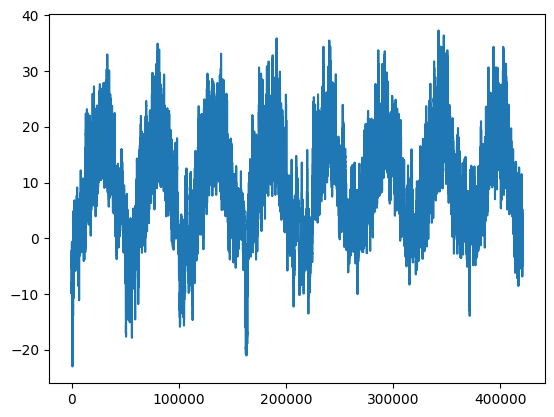

In [10]:
import matplotlib.pyplot as plt

# Plot of temperature data over time (or over the dataset)
plt.plot(range(len(temperature)),temperature)

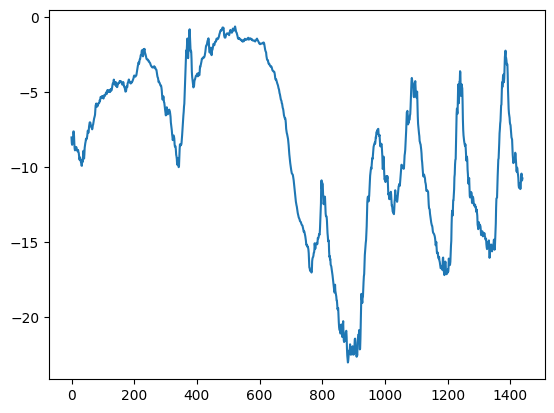

In [11]:
# Top 1440 records of temperature distribution over time
plt.plot(range(1440),temperature[:1440])

In [12]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data)) 
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

# 50% - train data , 25 % validation data , 25% test data

In [13]:
# Normalizing the entire dataset based on the mean and standard deviation of the training data(since each feature has different scales)
# Can also be done using Standard Scaler
mean = raw_data[:num_train_samples].mean(axis=0)
std = raw_data[:num_val_samples].std(axis=0)

raw_data = (raw_data-mean) / std

In [14]:
# Creating the datasets

sampling_rate = 6 # Out of 6, only 1 data point will be taken
sequence_length = 120 # Previous 5 days data will be taken into account for predicting the new data points
delay = sampling_rate * (sequence_length + 24 - 1) # Target of the sequence will be temperature 24 hours after the end of sequence
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle=True,
    batch_size = batch_size,
    start_index=0,
    end_index = num_train_samples
)

validation_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle=True,
    batch_size = batch_size,
    start_index=num_train_samples,
    end_index = num_train_samples + num_val_samples
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle=True,
    batch_size = batch_size,
    start_index=num_train_samples + num_val_samples
)


In [15]:
# Dropouts for RNN Models should be applied consistently and constant mask needs to be applied for every timestamp ( constant dropout mask should be applied to the inner recurrent activations of a layer)


In [16]:
from keras.layers import LSTM, Dense , Dropout
from keras.callbacks import ModelCheckpoint

In [17]:
# LSTM Model with Dropout

input_layer = Input(shape=(sequence_length,raw_data.shape[-1]))

lstm_layer = LSTM(32,recurrent_dropout=0.25,unroll=True)(input_layer) # Unroll so that while running on GPU, the training is faster but however the model takes more memory consumption(use for smaller RNN models)
dropout_layer = Dropout(0.5)(lstm_layer)
output_layer = Dense(1)(dropout_layer)

model3 = Model(input_layer,output_layer)

model3.compile(optimizer="rmsprop",loss="mse",metrics="mae")

callback_list = [
    ModelCheckpoint(filepath="timeseries_lstm_dropout.keras",save_best_only=True)
]

history3 = model3.fit(train_dataset,epochs=2,validation_data=validation_dataset,callbacks=callback_list)
history3

Epoch 1/2


In [ ]:
from keras.layers import GRU

In [ ]:
# Using GRU and stacking together( GRU is a more streamlined version of LSTM layer)

input_layer = Input(shape=(sequence_length,raw_data.shape[-1]))

gru_layer1 = GRU(32,recurrent_dropout=0.5,return_sequence=True)(input_layer)
gru_layer2 = GRU(32,recurrent_dropout=0.5)(gru_layer1)
dropout_layer = Dropout(0.5)(gru_layer2)
output_layer = Dense(1)(dropout_layer)

model4 = Model(input_layer,output_layer)

model4.compile(optimizer="rmsprop",loss="mse",metrics="mae")

callback_list = [
    ModelCheckpoint(filepath="timeseries_stacked_gru_dropout.keras",save_best_only=True)
]

history4 = model4.fit(train_dataset,epochs=2,validation_data=validation_dataset,callbacks=callback_list)
history4

In [ ]:
# Bidirectional RNNs : Simple RNN layers like LSTM and GRU are highly dependent on the order of the input data in sequence
# With bidirectional RNN, we first process the input data in both the directions use LSTM and RNN individually, then merge with their representations
# Bidirectional RNN - Mostly used in NLP tasks

In [ ]:
from keras.layers import Bidirectional

input_layer = Input(shape=(sequence_length,raw_data.shape[-1]))

bidirectional_layer = Bidirectional(LSTM(16))(input_layer)
output_layer = Dense(1)(bidirectional_layer)

model5 = Model(input_layer,output_layer)

model5.compile(optimizer="rmsprop",loss="mse",metrics="mae")

callback_list = [
    ModelCheckpoint(filepath="timeseries_stacked_gru_dropout.keras",save_best_only=True)
]

history5 = model5.fit(train_dataset,epochs=2,validation_data=validation_dataset,callbacks=callback_list)
history5